<a href="https://colab.research.google.com/github/Qhwelah/NeuralBlock-NeuralNetPredictor/blob/main/NeuralNetPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Prepping for the Models**

In [52]:
# !pip3 uninstall gdown -y && pip3 install gdown
import gdown

url = "https://drive.google.com/uc?id=1TOCQLuu6jvplsd3wzFwPSNG-mFSbKzAa"
output = "data.csv"
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1TOCQLuu6jvplsd3wzFwPSNG-mFSbKzAa
From (redirected): https://drive.google.com/uc?id=1TOCQLuu6jvplsd3wzFwPSNG-mFSbKzAa&confirm=t&uuid=b2002847-3682-49bb-a90c-519465f5e139
To: /content/data.csv
100%|██████████| 469M/469M [00:03<00:00, 148MB/s]


'data.csv'

In [53]:
## import the data
import pandas as pd

df = pd.read_csv("data.csv")

print(df)

       xRot   yRot        block_1  block_1_dist        block_2  block_2_dist  \
0     33.30 -89.54  minecraft:air         64.40  minecraft:air         64.20   
1     33.30 -89.54  minecraft:air         64.40  minecraft:air         64.20   
2     28.20 -87.29  minecraft:air         64.48  minecraft:air         64.33   
3     25.35 -55.34  minecraft:air         63.55  minecraft:air         63.76   
4     26.10 -35.99  minecraft:air         64.04  minecraft:air         64.04   
...     ...    ...            ...           ...            ...           ...   
5542  13.95 -33.61  minecraft:air         63.96  minecraft:air         63.98   
5543  17.85 -32.41  minecraft:air         63.54  minecraft:air         63.54   
5544  21.30 -25.06  minecraft:air         64.00  minecraft:air         64.19   
5545  23.70  -1.21  minecraft:air         64.38  minecraft:air         64.16   
5546  23.70  -1.96  minecraft:air         64.35  minecraft:air         63.55   

            block_3  block_3_dist      

In [54]:
## Getting all values of non-numeric types only
df.info()
non_numeric_values = df.select_dtypes(exclude=["float", "int"])
# print(non_numeric_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5547 entries, 0 to 5546
Columns: 7202 entries, xRot to block_3600_dist
dtypes: float64(3602), object(3600)
memory usage: 304.8+ MB


In [55]:
## Mapping all non-numeric data values to some numeric values

# parameters:
columns_to_check_for_unique_values = 20

# internal values:
block_mapping_conversions = []

print("Event log for block conversion pushes: ")
j = 1  # iterator for determining which block column to use
while(j < columns_to_check_for_unique_values+1):
  block_column = f"block_{j}"
  block_mapping = df[block_column].factorize()
  # print(f"Conversion values for {block_column}: ")
  # print(block_mapping)
  # print()
  i = 0  # iterator for checking within a single column's conversion mapping
  while i < len(block_mapping[0]):
    mapped_index = block_mapping[0][i]
    if mapped_index == -1:
      i += 1
      continue
    new_conversion = block_mapping[1][mapped_index]
    if new_conversion not in block_mapping_conversions:
      block_mapping_conversions.append(new_conversion)
      print(f"pushing {new_conversion} to values at index {len(block_mapping_conversions)-1}")
    i += 1
  j += 1

block_mapping_conversions.append('unknown')
print(f"pushing unknown to values at index {len(block_mapping_conversions)-1}")

print()
print("Final conversion values: ")
print(block_mapping_conversions)

Event log for block conversion pushes: 
pushing minecraft:air to values at index 0
pushing minecraft:stone to values at index 1
pushing minecraft:grass_block to values at index 2
pushing minecraft:oak_log to values at index 3
pushing minecraft:oak_planks to values at index 4
pushing minecraft:oak_leaves to values at index 5
pushing minecraft:dirt to values at index 6
pushing minecraft:water to values at index 7
pushing unknown to values at index 8

Final conversion values: 
['minecraft:air', 'minecraft:stone', 'minecraft:grass_block', 'minecraft:oak_log', 'minecraft:oak_planks', 'minecraft:oak_leaves', 'minecraft:dirt', 'minecraft:water', 'unknown']


In [56]:
## Converting actual data values in the dataframe to numbers using block mapping
def convertBlock(val):
  for i in range(len(block_mapping_conversions)):
    if val == block_mapping_conversions[i]:
      return i
  return -1

block_columns = [col for col in df.columns if col.startswith("block_") and not col.endswith("_dist")]
# print(block_columns)
df_numerical = df.copy() # make a backup copy of the dataframe to reference later
for col in block_columns:
  df_numerical[col] = df_numerical[col].apply(convertBlock)

print()
print(df_numerical) # the numerized dataframe


       xRot   yRot  block_1  block_1_dist  block_2  block_2_dist  block_3  \
0     33.30 -89.54        0         64.40        0         64.20        0   
1     33.30 -89.54        0         64.40        0         64.20        0   
2     28.20 -87.29        0         64.48        0         64.33        0   
3     25.35 -55.34        0         63.55        0         63.76        0   
4     26.10 -35.99        0         64.04        0         64.04        0   
...     ...    ...      ...           ...      ...           ...      ...   
5542  13.95 -33.61        0         63.96        0         63.98        0   
5543  17.85 -32.41        0         63.54        0         63.54        0   
5544  21.30 -25.06        0         64.00        0         64.19        0   
5545  23.70  -1.21        0         64.38        0         64.16        0   
5546  23.70  -1.96        0         64.35        0         63.55        0   

      block_3_dist  block_4  block_4_dist  ...  block_3596  block_3596_dis

# **KNN Model Predictions**

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [58]:
distance_columns = [col for col in df_numerical.columns if 'dist' in col]

target_distance_column = 'block_5_dist'

for col in distance_columns:
    if col != target_distance_column:
        df_numerical[col] = (df_numerical[col] - df_numerical[target_distance_column]).abs()

df_numerical = df_numerical.drop(columns=[target_distance_column])

In [59]:
target_block = 'block_5'

X = df_numerical.drop(columns=[target_block])
y = df_numerical[target_block]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [60]:
knn = KNeighborsClassifier(n_neighbors=26, weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=26, weights='distance')

In [61]:
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"KNN model accuracy: {accuracy:.2f}")

KNN model accuracy: 0.75


# **Neural Network via TensorFlow Predictions**

In [62]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# **Data Masking and Test/Train Splits**



In [63]:
def mask_entries(X, mask_candidate_column_indices, missing_val=9, missing_rate=0.1):
    print("started")
    X_masked = X.copy()
    mask = pd.DataFrame(False, index=X.index, columns=X.columns)
    print("copies made")

    # Randomly selects (missing_rate)% of the data columns provided in mask_candidate_column_indices
    #  to "mask" (swap out for the missing_val) for each individual data row.
    for i in range(X.shape[0]):  # for each row
        num_mask = max(1, int(len(mask_candidate_column_indices) * missing_rate))
        mask_indices = np.random.choice(mask_candidate_column_indices, num_mask, replace=False)
        mask_columns = X.columns[mask_indices]
        # print(mask_indices)
        X_masked.loc[i, mask_columns] = missing_val
        mask.loc[i, mask_columns] = True  # track what was masked

    print("Exited masking loop")
    return X_masked, mask

In [64]:
## Parameters --- ##
# Percentage of data to mask and ask the model to fill in (0-1):
missing_rate = 0.1
# The location in the conversion list where the 'unknown' conversion was appended
missing_val = len(block_mapping_conversions)-1
## -------------- ##

# Data prepping
X_NN = df_numerical.copy()
print(X_NN.shape)

# Train/Test splits
from sklearn.model_selection import train_test_split
X_NN_train, X_NN_test = train_test_split(X_NN, test_size=0.2, random_state=42)

# Save current indices from overall list and reset the train/test indices each starting at index 0
train_indices = X_NN_train.index.copy()
test_indices = X_NN_test.index.copy()
X_NN_train = X_NN_train.reset_index(drop=True)
X_NN_test = X_NN_test.reset_index(drop=True)

# Masking data in each row for prediction later
masking_candidates = [col for col in df_numerical.columns if not col.endswith("_dist") and not col.endswith("Rot")]
  # exclude rotation values from masking, as well as distance values. Currently it only subs in fake *block ids*, not distances.
# masking_candidate_indices = [df_numerical.columns.get_loc(col) for col in masking_candidates]
X_NN_train_blocks = X_NN_train[masking_candidates]
X_NN_test_blocks = X_NN_test[masking_candidates]

# X_NN_train_masked, train_mask = mask_entries(X_NN_train, masking_candidate_indices, missing_val, missing_rate)
# X_NN_test_masked, test_mask = mask_entries(X_NN_test, masking_candidate_indices, missing_val, missing_rate)

print("Training data:")
print(X_NN_train_blocks.shape)

print()
print("Testing data:")
print(X_NN_test_blocks.shape)

(5547, 7201)
Training data:
(4437, 3600)

Testing data:
(1110, 3600)


In [65]:
print("Training data:")
print(X_NN_train_blocks)

print()
print("Testing data:")
print(X_NN_test_blocks)

Training data:
      block_1  block_2  block_3  block_4  block_5  block_6  block_7  block_8  \
0           1        1        1        1        1        1        1        1   
1           1        1        1        1        1        1        1        6   
2           3        3        3        3        3        3        3        3   
3           1        1        1        1        1        1        1        1   
4           1        1        1        1        1        1        1        1   
...       ...      ...      ...      ...      ...      ...      ...      ...   
4432        6        6        6        6        6        6        6        6   
4433        5        5        5        5        5        5        5        5   
4434        5        5        5        5        5        5        5        5   
4435        0        0        0        0        0        0        0        0   
4436        1        1        1        1        1        1        1        1   

      block_9  block_10 

# **TensorFlow Model**

In [66]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [67]:
X_train_input = X_NN_train_masked.values  # Masked input
y_train_target = X_NN_train.values        # Original target

X_test_input = X_NN_test_masked.values
y_test_target = X_NN_test.values

# Model building
input_dim = X_train_input.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(2048, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(input_dim)  # output size = input size, no activation
])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 2048)           │    14,749,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7201)           │     3,694,113 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,066,785 (80.36 MB)

 Trainable params: 21,066,785 (80.36 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Define the loss function
def masked_mse_loss(y_true, y_pred):
    missing_val = 9.0  # whatever you used during masking

    # Create a mask: 1 if y_true == missing_val, else 0
    mask = tf.cast(tf.equal(y_true, missing_val), dtype=tf.float32)

    # Loss only where mask == 1
    loss = tf.square(y_true - y_pred) * mask

    # Average the loss only over the masked elements
    loss_sum = tf.reduce_sum(loss)
    num_masked = tf.reduce_sum(mask)

    # avoid division by zero
    return tf.cond(num_masked > 0, lambda: loss_sum / num_masked, lambda: tf.constant(0.0))

# MSE - Penalized for being out of range
def masked_mse_with_range_penalty(y_true, y_pred):
    missing_val = 9.0
    max_block_value = len(block_mapping_conversions) - 1

    # Mask: where the ground truth had missing values
    mask = tf.cast(tf.equal(y_true, missing_val), dtype=tf.float32)

    # Standard MSE Loss only at masked points
    mse_loss = tf.square(y_true - y_pred) * mask

    # Range penalty: punish predictions outside [0, max_block_value]
    lower_violation = tf.nn.relu(0.0 - y_pred)  # how far below 0
    upper_violation = tf.nn.relu(y_pred - max_block_value)  # how far above max
    range_penalty = (lower_violation + upper_violation) * mask  # only on masked parts

    # Sum up both losses
    total_loss = tf.reduce_sum(mse_loss) + tf.reduce_sum(range_penalty)

    # Average over number of masked entries (avoid divide by 0)
    num_masked = tf.reduce_sum(mask)
    return tf.cond(num_masked > 0, lambda: total_loss / num_masked, lambda: tf.constant(0.0))


In [69]:
# Compiling the TensorFlow model
# model.compile(optimizer='adam', loss=masked_mse_loss)

model.compile(optimizer='adam', loss=masked_mse_with_range_penalty)

In [70]:
num_blocks = len(block_columns)
num_classes = len(block_mapping_conversions)

input_dim = X_NN_train_masked.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(2048, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(num_blocks * num_classes),  # final output
    layers.Reshape((num_blocks, num_classes)),  # reshape to (block, class probs)
    layers.Softmax(axis=-1)  # apply softmax on classes
])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 2048)           │    14,749,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32400)          │    33,210,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 3600, 9)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_1 (Softmax)             │ (None, 3600, 9)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,057,872 (190.96 MB)

 Trainable params: 50,057,872 (190.96 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    missing_val = len(block_mapping_conversions)-1  # your masking value

    # y_true shape: (batch_size, num_blocks)
    # y_pred shape: (batch_size, num_blocks, num_classes)

    # Create mask: where y_true == missing_val
    mask = tf.cast(tf.not_equal(y_true, missing_val), dtype=tf.float32)  # note NOT_EQUAL because masked parts were originally missing
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    loss = loss * mask  # apply mask

    total_loss = tf.reduce_sum(loss)
    num_masked = tf.reduce_sum(mask)

    return tf.cond(num_masked > 0, lambda: total_loss / num_masked, lambda: tf.constant(0.0))


In [72]:
model.compile(optimizer='adam', loss=masked_sparse_categorical_crossentropy)

In [73]:
history = model.fit(
    X_NN_train_masked.values,
    X_NN_train_blocks.values,  # Only the block_x columns!
    validation_data=(X_NN_test_masked.values, X_NN_test_blocks.values),
    epochs=50,
    batch_size=32
)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2.2046 - val_loss: 0.0000e+00
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.7915 - val_loss: 0.0000e+00
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.7435 - val_loss: 0.0000e+00
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.6527 - val_loss: 0.0000e+00
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.6211 - val_loss: 0.0000e+00
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.6074 - val_loss: 0.0000e+00
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.5623 - val_loss: 0.0000e+00
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.5170 - val_loss: 0.0000e+00
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.4789 - val_loss: 0.0000e+00
Epoch 10/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.4374 - val_loss: 0.0000e+00
Epoch 11/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.4382 - val_loss: 0.0000e+

In [74]:
# applying the model to make our predictions
predictions = model.predict(X_test_input)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [75]:
# 1. Predict
predictions = model.predict(X_NN_test_masked.values)

# 2. Get classes
predicted_classes = predictions.argmax(axis=-1)

# 3. Get true classes
true_classes = X_NN_test_blocks.values

# 4. Mask only block_x columns
test_mask_blocks = test_mask[block_columns]

# 5. Flatten and apply mask
y_true = true_classes.flatten()
y_pred = predicted_classes.flatten()
mask = test_mask_blocks.values.flatten()

masked_true = y_true[mask]
masked_pred = y_pred[mask]

# 6. Accuracy
accuracy = (masked_true == masked_pred).sum() / len(masked_true)
print(f"Masked Prediction Accuracy: {accuracy:.4f}")

print(predictions)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Masked Prediction Accuracy: 0.5322
[[[1.33521506e-04 7.73543667e-04 7.44708953e-03 ... 1.92581560e-03
   4.45783570e-08 5.61483314e-13]
  [6.34397111e-06 3.73108604e-04 6.94049522e-03 ... 1.68890809e-03
   3.59054127e-07 8.11935913e-13]
  [2.29706729e-05 2.96246755e-04 7.27514224e-03 ... 1.18491519e-03
   5.67078295e-09 1.06538096e-12]
  ...
  [4.09089588e-02 2.30465271e-03 9.03671682e-01 ... 7.59525364e-03
   5.17062181e-05 7.47562602e-13]
  [4.42625135e-02 2.78479117e-03 8.85758460e-01 ... 9.62194335e-03
   7.30583779e-05 2.25825456e-12]
  [4.42019403e-02 2.50753108e-03 8.84921610e-01 ... 7.82066677e-03
   3.61373131e-05 1.28688319e-11]]

 [[6.69574678e-01 5.81771582e-02 5.16802184e-02 ... 2.84128394e-02
   1.28901936e-02 2.96751386e-03]
  [6.79196835e-01 5.63575514e-02 5.07487990e-02 ... 2.80874781e-02
   1.33942561e-02 2.84732459e-03]
  [6.84870362e-01 5.78444116e-02 5.17154522e-02 ... 2.60719415e-02
   1.26099680e-02 2.92519829e-03]
  ...
  [

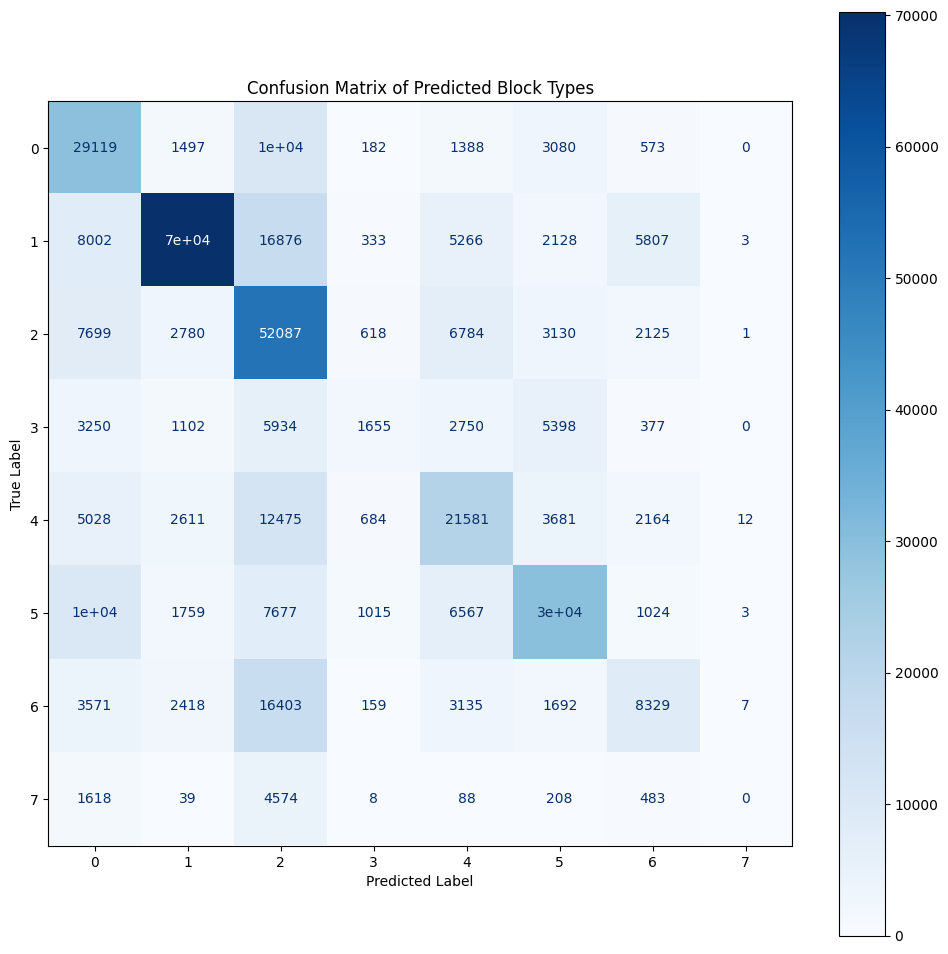

In [76]:
## Confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(masked_true, masked_pred)
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title('Confusion Matrix of Predicted Block Types')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# **Please ignore this is totally awesome and definitely works**

In [47]:
predictions_df = pd.DataFrame(predictions, columns=X_NN_test.columns)
print(predictions_df)

ValueError: Must pass 2-d input. shape=(1110, 3600, 9)

In [ ]:
# Data evaluations
# Get only the masked entries for evaluation
masked_positions = test_mask  # DataFrame with same shape

# Pull ground truth values where we masked
true_values = X_NN_test[masked_positions]

# Pull model predictions where we masked
predicted_values = predictions_df[masked_positions].round()

In [ ]:
# Flatten into 1D arrays for comparison
y_true = true_values.values.flatten()
y_pred = predicted_values.values.flatten()

# Find only where y_true is NOT NaN
valid_mask = ~np.isnan(y_true)
valid_mask &= ~np.isnan(y_pred)

# Apply mask
y_true_valid = y_true[valid_mask].astype(int)
y_pred_valid = y_pred[valid_mask].astype(int)

# Only compare where there was actually a masked entry
correct = (y_true_valid == y_pred_valid).sum()
total = len(y_true)

accuracy = correct / total
print(f"Masked prediction accuracy: {accuracy:.4f}")

Masked prediction accuracy: 0.0044


In [ ]:
# Model Training and Hyperparameters

history = model.fit(
    X_train_input, y_train_target,
    validation_data=(X_test_input, y_test_target),
    epochs=50,
    batch_size=32
)

Epoch 1/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 403ms/step - loss: 3338.9382 - val_loss: 63.9981
Epoch 2/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 427ms/step - loss: 64.6215 - val_loss: 92.8678
Epoch 3/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 81s 421ms/step - loss: 33.1693 - val_loss: 56.0731
Epoch 4/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 80s 404ms/step - loss: 25.1974 - val_loss: 55.3736
Epoch 5/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 404ms/step - loss: 18.8072 - val_loss: 53.4562
Epoch 6/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 84s 418ms/step - loss: 15.9193 - val_loss: 58.0046
Epoch 7/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 82s 422ms/step - loss: 12.6971 - val_loss: 52.6226
Epoch 8/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 84s 439ms/step - loss: 8.2046 - val_loss: 48.5727
Epoch 9/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 428ms/step - loss: 7.9429 - val_loss: 52.2749
Epoch 10/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 69s 497ms/step - loss: 4.9298 - val_loss: 46.0364
Epoch 11/50
139/139 ━━━━━━━━━━━━━━━━━━━━ 77s 461ms/step - loss: 5.4828 - val_loss: 52.4017

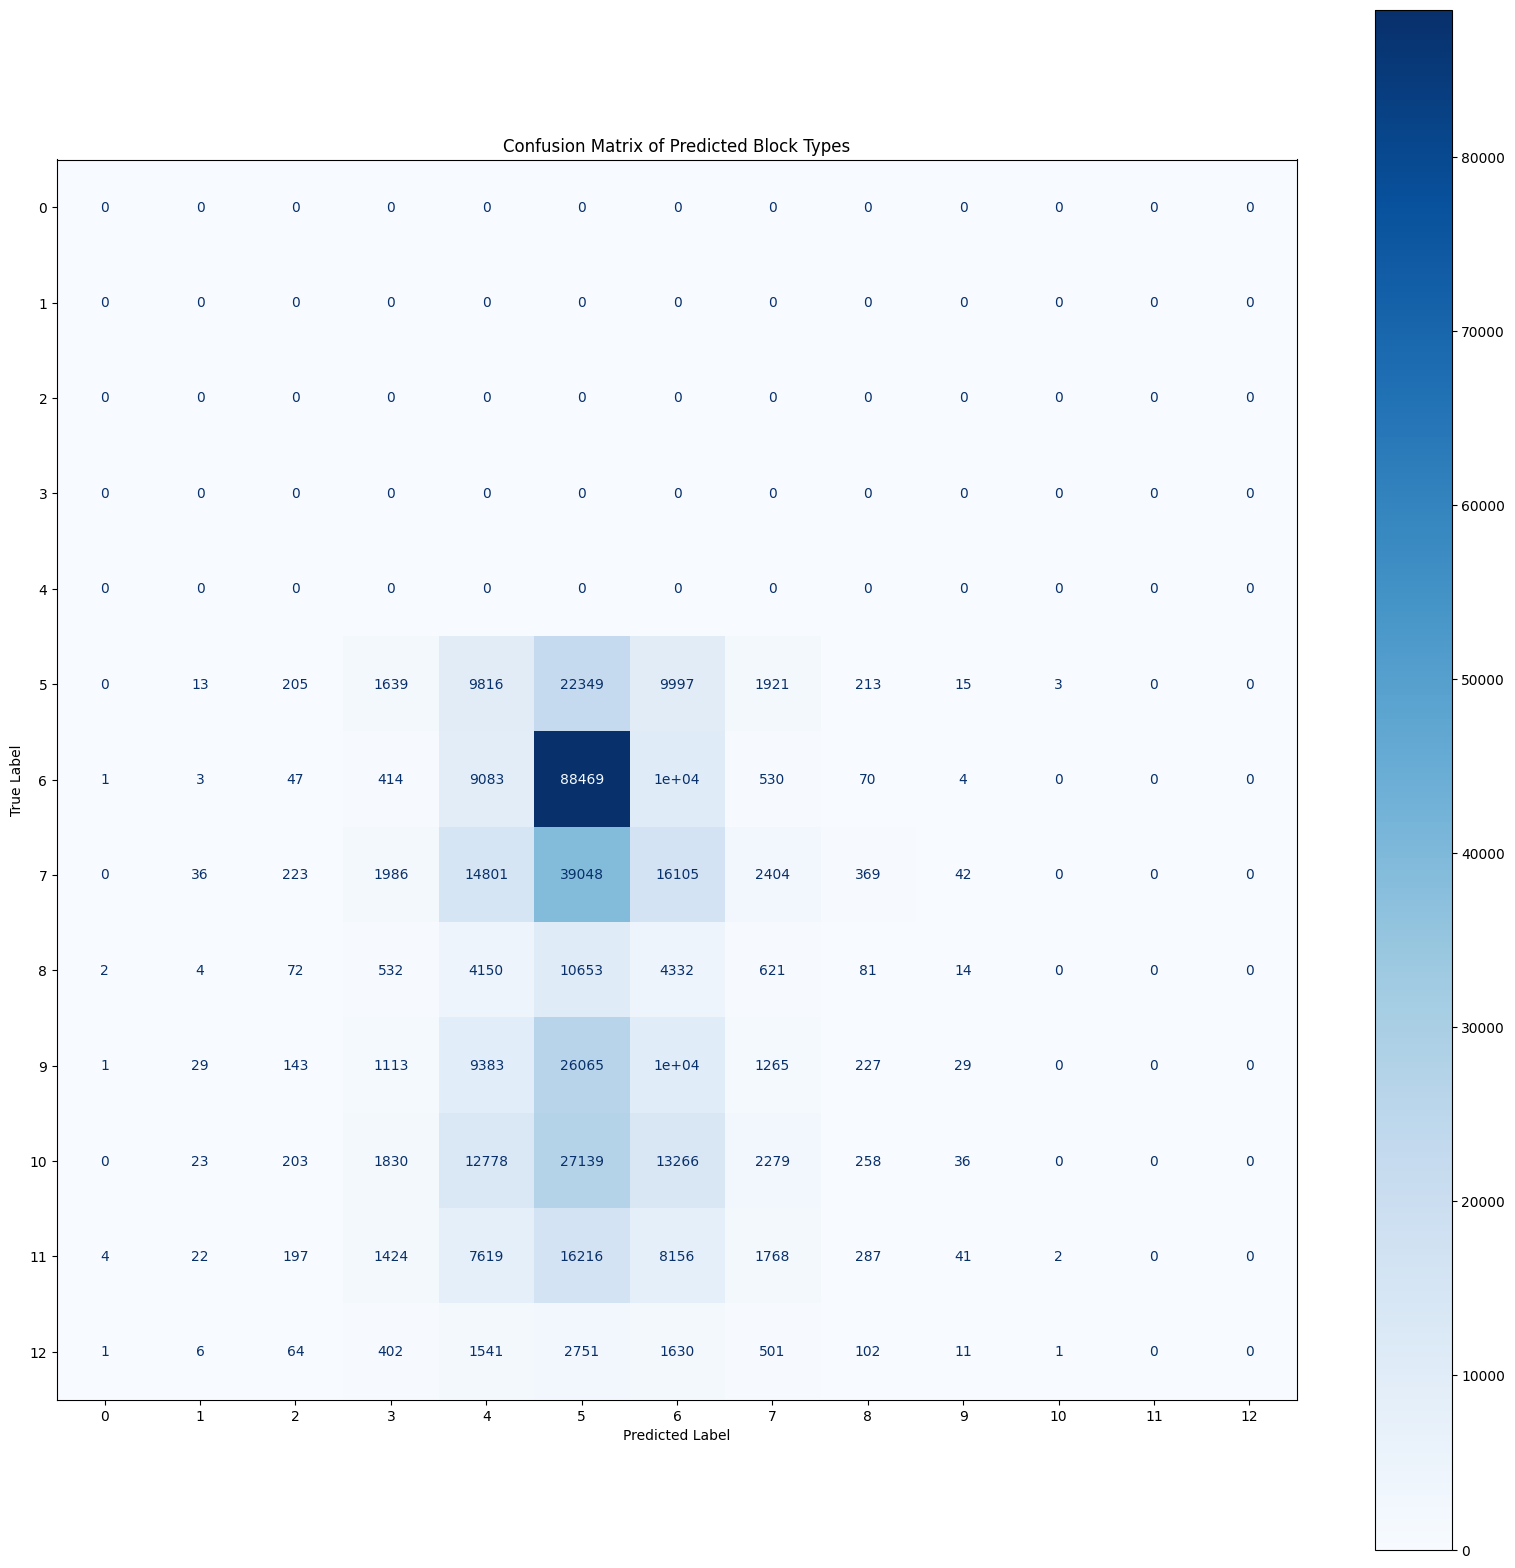

In [ ]:
## Confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Build confusion matrix
cm = confusion_matrix(y_true_valid, y_pred_valid)

# Plot
fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax, cmap='Blues', colorbar=True)
plt.title('Confusion Matrix of Predicted Block Types')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()